## model try


### Load libraries

In [1]:
from cv2 import cv2
import os
import json
import time

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from src.data.my_dataset import XRayDataSet
from src.data.my_dataset import collate_fn
from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch

In [7]:
dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist'))

In [8]:
training_dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4,collate_fn=collate_fn)

In [9]:
images , targets = next(iter(training_dataloader))

In [5]:
images

('..\\literature\\Other\\supervisely\\wrist\\img\\0001_1297860395_01_WRI-L1_M014.png',
 '..\\literature\\Other\\supervisely\\wrist\\img\\0003_0664918633_03_WRI-R1_M011.png')

In [146]:
for img in images:
    print(img)
    print(img.squeeze(dim=0).shape)

tensor([[[[2.7237e-05, 2.8224e-05, 2.8176e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7876e-05, 2.8224e-05, 2.7769e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7915e-05, 2.7885e-05, 2.7556e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4692e-05,
           2.5273e-05, 1.7049e-05],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.5263e-05,
           2.5737e-05, 1.7484e-05],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.5689e-05,
           2.6415e-05, 1.7813e-05]]]])
torch.Size([1, 836, 536])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
torch.Size([1, 1198, 469])


In [147]:
imgs =list(img.squeeze(dim=0) for img in images)
annotations = [{k: v for k, v in t[0].items()} for t in targets]


In [148]:
imgs

[tensor([[[2.7237e-05, 2.8224e-05, 2.8176e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7876e-05, 2.8224e-05, 2.7769e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.7915e-05, 2.7885e-05, 2.7556e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4692e-05,
           2.5273e-05, 1.7049e-05],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.5263e-05,
           2.5737e-05, 1.7484e-05],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.5689e-05,
           2.6415e-05, 1.7813e-05]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]])]

In [103]:
annotations

[{'boxes': tensor([[ 31., 680.,  84., 745.],
          [180., 428., 356., 508.]]),
  'labels': tensor([2, 1]),
  'image_id': tensor([1]),
  'area': [3445, 14080],
  'iscrowd': tensor([0, 0, 0,  ..., 0, 0, 0])},
 {'boxes': tensor([[368., 111., 403., 150.]]),
  'labels': tensor([2]),
  'image_id': tensor([3]),
  'area': [1365],
  'iscrowd': tensor([0, 0, 0,  ..., 0, 0, 0])}]

In [2]:
def get_model_instance_segmentation(num_classes):
      
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [106]:
model = get_model_instance_segmentation(3)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [107]:
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [149]:
loss_dict = model(imgs, annotations) 
losses = sum(loss for loss in loss_dict.values())

In [150]:
losses

tensor(2.1008, grad_fn=<AddBackward0>)

In [151]:
model.eval()
x = torch.rand(1, 3, 600, 1200) #[torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [21]:
#dummy boxes and images format
images, boxes = torch.rand(2, 3, 600, 1200), torch.rand(1, 2, 4) 
labels = torch.randint(1, 91, (1, 2))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [23]:
images

[tensor([[[0.0717, 0.0286, 0.0509,  ..., 0.4636, 0.6793, 0.5114],
          [0.1724, 0.3067, 0.2036,  ..., 0.4537, 0.1944, 0.4012],
          [0.9865, 0.4855, 0.1253,  ..., 0.2531, 0.5730, 0.9984],
          ...,
          [0.4158, 0.6109, 0.7993,  ..., 0.8923, 0.1082, 0.1951],
          [0.8729, 0.7639, 0.6863,  ..., 0.7586, 0.0713, 0.3875],
          [0.7933, 0.4963, 0.0960,  ..., 0.6684, 0.1858, 0.8943]],
 
         [[0.7630, 0.0583, 0.2938,  ..., 0.5966, 0.4186, 0.3203],
          [0.6471, 0.8236, 0.4187,  ..., 0.5066, 0.5937, 0.0471],
          [0.3434, 0.5973, 0.7518,  ..., 0.1554, 0.8862, 0.5466],
          ...,
          [0.6144, 0.0761, 0.2139,  ..., 0.9590, 0.5755, 0.5851],
          [0.4597, 0.8979, 0.8501,  ..., 0.1220, 0.4932, 0.0971],
          [0.2272, 0.1530, 0.2141,  ..., 0.2095, 0.4813, 0.4702]],
 
         [[0.9328, 0.7216, 0.3283,  ..., 0.5375, 0.7323, 0.1995],
          [0.6004, 0.0217, 0.8414,  ..., 0.6681, 0.4907, 0.0970],
          [0.8629, 0.1133, 0.0012,  ...,

## Real try of the Model

In [42]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [8]:
#keep only predictions with score higher than the threshold
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    print(preds)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [7]:
#load train data
train_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/train_pickles'))
training_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4,collate_fn=collate_fn)

#load validation data
validation_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/validation_pickles'))
validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False, num_workers=4,collate_fn=collate_fn)

#load test data
test_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles'))
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4,collate_fn=collate_fn)

In [45]:
model = get_model_instance_segmentation(3)

In [46]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

num_epochs = 3

In [50]:
#test how i can move every annotation to device
device = 'cpu'


for annotation in annotations:
    for key, value in annotation.items():
        if isinstance(value, torch.Tensor):
            annotation[key] = value.to(device)



annotations


[{'boxes': tensor([[ 40., 305., 107., 427.]]),
  'labels': tensor([2]),
  'image_id': tensor([453]),
  'area': tensor([8174]),
  'iscrowd': tensor([0, 0, 0,  ..., 0, 0, 0])},
 {'boxes': tensor([[163., 482., 281., 609.],
          [ 51., 272.,  89., 338.]]),
  'labels': tensor([1, 2]),
  'image_id': tensor([131]),
  'area': tensor([14986,  2508]),
  'iscrowd': tensor([0, 0, 0,  ..., 0, 0, 0])}]

In [48]:
print('----------------------train started--------------------------')

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in tqdm(training_dataloader):
        i += 1
        imgs =list(img.squeeze(dim=0).to(device) for img in imgs)
        annotations = [{k: v for k, v in t[0].items()} for t in annotations]

        ####-----------MOVE annotations to device---------------#####

        # Iterate over the list of dicts and move each tensor to the device
        for annotation in annotations:
            for key, value in annotation.items():
                if isinstance(value, torch.Tensor):
                    annotation[key] = value.to(device)
        
        ####-----------MOVE annotations to device---------------#####


        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

print('----------------------train ended--------------------------')

----------------------train started--------------------------


  0%|          | 0/350 [00:33<?, ?it/s]


KeyboardInterrupt: 

In [79]:
#save the model state
torch.save(model.state_dict(),f'my_first_model.pt')


In [4]:
#load the model state

model = get_model_instance_segmentation(3)
model.load_state_dict(torch.load(f'test.pt',map_location=torch.device('cpu')))


<All keys matched successfully>

In [5]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img,cmap='gray')
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].detach().numpy()

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [9]:
#make a single prediction based on the train
with torch.no_grad(): 
    # batch size of the test set = 2
    for imgs, annotations in test_dataloader:
        imgs = list(img.squeeze(dim=0) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)

        print(pred)
        break

[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]
[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]


In [22]:
model.eval()
images , targets = next(iter(training_dataloader))
predictions = model(images[0])

Target :  tensor([2, 1])


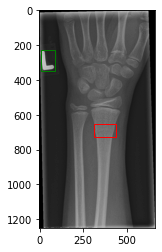

In [23]:
print("Target : ",targets[0][0]['labels'])
plot_image_from_output(images[0][0], targets[0][0])

Prediction :  tensor([], dtype=torch.int64)


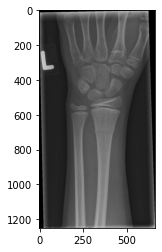

In [24]:
print("Prediction : ", predictions[0]['labels'])
plot_image_from_output(images[0][0],predictions[0])

In [51]:
import torch
print(torch.__version__)

1.11.0


In [ ]:
#plot validation loss over training
plt.plot(list(range(0,epochs)), train_loss, color='blue', label='Train loss')
plt.plot(list(range(0,epochs)), val_loss, color = 'red', label='Validation loss')
plt.legend()

In [25]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

In [26]:
lr_scheduler